<a href="https://colab.research.google.com/github/imancn/nlp-word2vec/blob/main/NLP_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Masnavi Word2Vec**

## **Imports**

In [ ]:
from __future__ import absolute_import, division, print_function

In [ ]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [ ]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Prepare Corpus**

**Load books from files**

In [ ]:
book_filenames = sorted(glob.glob("/content/*.txt"))
print("Found books:")
book_filenames

Found books:


['/content/DOC2.txt']

**Combine the books into one string**

In [ ]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print(corpus_raw)

Reading '/content/DOC2.txt'...
Corpus is now 225910 characters long
مدتى اين مثنوى تاخير شد    مهلتى بايست تا خون شير شد
تا نزايد بخت تو فرزند نو    خون، نگردد شير شيرين خوش شنو
چون ضياء الحق حسام الدين عنان    باز گردانيد ز اوج آسمان‏
چون به معراج حقايق رفته بود    بى‏بهارش غنچه‏ها نشكفته بود
چون ز دريا سوى ساحل باز گشت    چنگ شعر مثنوى با ساز گشت‏
مثنوى كه صيقل ارواح بود    باز گشتش روز استفتاح بود
مطلع تاريخ اين سودا و سود    سال اندر ششصد و شصت و دو بود
بلبلى ز ينجا برفت و باز گشت    بهر صيد اين معانى باز گشت‏
ساعد شه مسكن اين باز باد    تا ابد بر خلق اين در باز باد
آفت اين در هوا و شهوت است    ور نه اينجا شربت اندر شربت است‏
اين دهان بر بند تا بينى عيان    چشم بند آن جهان حلق و دهان‏
اى دهان تو خود دهانه‏ى دوزخى    وى جهان تو بر مثال برزخى‏
نور باقى پهلوى دنياى دون    شير صافى پهلوى جوهاى خون‏
چون در او گامى زنى بى‏احتياط    شير تو خون مى‏شود از اختلاط
يك قدم زد آدم اندر ذوق نفس    شد فراق صدر جنت طوق نفس‏
همچو ديو از وى فرشته مى‏گريخت    بهر نانى چند آب چشم ريخت‏
گر چه يك مو بد گ

**Split the corpus into sentences**

In [ ]:
corpus_raw = corpus_raw.replace('\r', '')
corpus_raw = corpus_raw.replace('\u200f', '')
raw_sentences = re.split('\n|\t', corpus_raw)
print(raw_sentences)
print(len(raw_sentences))

['مدتى اين مثنوى تاخير شد    مهلتى بايست تا خون شير شد', 'تا نزايد بخت تو فرزند نو    خون، نگردد شير شيرين خوش شنو', 'چون ضياء الحق حسام الدين عنان    باز گردانيد ز اوج آسمان', 'چون به معراج حقايق رفته بود    بىبهارش غنچهها نشكفته بود', 'چون ز دريا سوى ساحل باز گشت    چنگ شعر مثنوى با ساز گشت', 'مثنوى كه صيقل ارواح بود    باز گشتش روز استفتاح بود', 'مطلع تاريخ اين سودا و سود    سال اندر ششصد و شصت و دو بود', 'بلبلى ز ينجا برفت و باز گشت    بهر صيد اين معانى باز گشت', 'ساعد شه مسكن اين باز باد    تا ابد بر خلق اين در باز باد', 'آفت اين در هوا و شهوت است    ور نه اينجا شربت اندر شربت است', 'اين دهان بر بند تا بينى عيان    چشم بند آن جهان حلق و دهان', 'اى دهان تو خود دهانهى دوزخى    وى جهان تو بر مثال برزخى', 'نور باقى پهلوى دنياى دون    شير صافى پهلوى جوهاى خون', 'چون در او گامى زنى بىاحتياط    شير تو خون مىشود از اختلاط', 'يك قدم زد آدم اندر ذوق نفس    شد فراق صدر جنت طوق نفس', 'همچو ديو از وى فرشته مىگريخت    بهر نانى چند آب چشم ريخت', 'گر چه يك مو بد گنه كاو جسته بود    ليك آن مو در د

In [ ]:
# A 2D array to store words of each sentences
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(raw_sentence.split())

In [ ]:
print(raw_sentences)
print(sentences)
print(sentences[1])

['مدتى اين مثنوى تاخير شد    مهلتى بايست تا خون شير شد', 'تا نزايد بخت تو فرزند نو    خون، نگردد شير شيرين خوش شنو', 'چون ضياء الحق حسام الدين عنان    باز گردانيد ز اوج آسمان', 'چون به معراج حقايق رفته بود    بىبهارش غنچهها نشكفته بود', 'چون ز دريا سوى ساحل باز گشت    چنگ شعر مثنوى با ساز گشت', 'مثنوى كه صيقل ارواح بود    باز گشتش روز استفتاح بود', 'مطلع تاريخ اين سودا و سود    سال اندر ششصد و شصت و دو بود', 'بلبلى ز ينجا برفت و باز گشت    بهر صيد اين معانى باز گشت', 'ساعد شه مسكن اين باز باد    تا ابد بر خلق اين در باز باد', 'آفت اين در هوا و شهوت است    ور نه اينجا شربت اندر شربت است', 'اين دهان بر بند تا بينى عيان    چشم بند آن جهان حلق و دهان', 'اى دهان تو خود دهانهى دوزخى    وى جهان تو بر مثال برزخى', 'نور باقى پهلوى دنياى دون    شير صافى پهلوى جوهاى خون', 'چون در او گامى زنى بىاحتياط    شير تو خون مىشود از اختلاط', 'يك قدم زد آدم اندر ذوق نفس    شد فراق صدر جنت طوق نفس', 'همچو ديو از وى فرشته مىگريخت    بهر نانى چند آب چشم ريخت', 'گر چه يك مو بد گنه كاو جسته بود    ليك آن مو در د

In [ ]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))
print("Sentences count: {0:,}".format(len(sentences)))

The book corpus contains 49,669 tokens
Sentences count: 3,924


## **Creating and configure Word2Vec model**

Creating and configure Word2Vec model

In [ ]:
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

Building word vocabulary

In [ ]:
model.build_vocab(sentences)
print("Word2Vec vocabulary length:", len(model.wv.vocab))

2021-04-25 10:31:24,981 : INFO : collecting all words and their counts
2021-04-25 10:31:24,985 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-25 10:31:25,011 : INFO : collected 8142 word types from a corpus of 49669 raw words and 3924 sentences
2021-04-25 10:31:25,020 : INFO : Loading a fresh vocabulary
2021-04-25 10:31:25,057 : INFO : effective_min_count=3 retains 2402 unique words (29% of original 8142, drops 5740)
2021-04-25 10:31:25,062 : INFO : effective_min_count=3 leaves 42639 word corpus (85% of original 49669, drops 7030)
2021-04-25 10:31:25,100 : INFO : deleting the raw counts dictionary of 8142 items
2021-04-25 10:31:25,102 : INFO : sample=0.001 downsamples 49 most-common words
2021-04-25 10:31:25,106 : INFO : downsampling leaves estimated 31318 word corpus (73.5% of prior 42639)
2021-04-25 10:31:25,127 : INFO : estimated required memory for 2402 words and 300 dimensions: 6965800 bytes
2021-04-25 10:31:25,133 : INFO : resetting layer weigh

Word2Vec vocabulary length: 2402


## **Training...**

In [ ]:
model.train(sentences, 
                    total_examples=model.corpus_count,
                    epochs=model.epochs)

2021-04-25 10:31:26,116 : INFO : training model with 2 workers on 2402 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2021-04-25 10:31:26,291 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 10:31:26,336 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 10:31:26,337 : INFO : EPOCH - 1 : training on 49669 raw words (31259 effective words) took 0.2s, 152585 effective words/s
2021-04-25 10:31:26,509 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 10:31:26,561 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 10:31:26,562 : INFO : EPOCH - 2 : training on 49669 raw words (31251 effective words) took 0.2s, 147166 effective words/s
2021-04-25 10:31:26,736 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-25 10:31:26,786 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-25 10:31:26,787 : INFO : EPOCH 

(3131820, 4966900)

**Save to file, can be useful later**

In [ ]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [ ]:
model.save(os.path.join("trained", "model.w2v"))

2021-04-25 10:31:48,427 : INFO : saving Word2Vec object under trained/model.w2v, separately None
2021-04-25 10:31:48,430 : INFO : not storing attribute vectors_norm
2021-04-25 10:31:48,432 : INFO : not storing attribute cum_table
2021-04-25 10:31:48,510 : INFO : saved trained/model.w2v


## **Explore the trained model.**

In [ ]:
model = w2v.Word2Vec.load(os.path.join("trained", "model.w2v"))

2021-04-25 10:31:48,521 : INFO : loading Word2Vec object from trained/model.w2v
2021-04-25 10:31:48,664 : INFO : loading wv recursively from trained/model.w2v.wv.* with mmap=None
2021-04-25 10:31:48,666 : INFO : setting ignored attribute vectors_norm to None
2021-04-25 10:31:48,669 : INFO : loading vocabulary recursively from trained/model.w2v.vocabulary.* with mmap=None
2021-04-25 10:31:48,672 : INFO : loading trainables recursively from trained/model.w2v.trainables.* with mmap=None
2021-04-25 10:31:48,674 : INFO : setting ignored attribute cum_table to None
2021-04-25 10:31:48,676 : INFO : loaded trained/model.w2v


Compress the word vectors into 2D space and plot them

In [ ]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = model.wv.syn0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


**Train t-SNE**

In [ ]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [ ]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [ ]:
points.head(10)
print(points)

         word          x          y
0        مدتى -13.441874   7.083885
1         اين  25.881533 -40.857838
2       مثنوى -11.680785   5.354213
3          شد  24.586060 -19.233284
4       بايست -12.240727   6.610755
...       ...        ...        ...
2397     عمرو  -5.149721 -21.108749
2398  مىباريد -10.698748   2.500942
2399      عنب   3.108189  31.784454
2400   حاجيان -19.145798 -25.853241
2401    باديه -18.300240 -25.024292

[2402 rows x 3 columns]


In [ ]:
sns.set_context("poster")

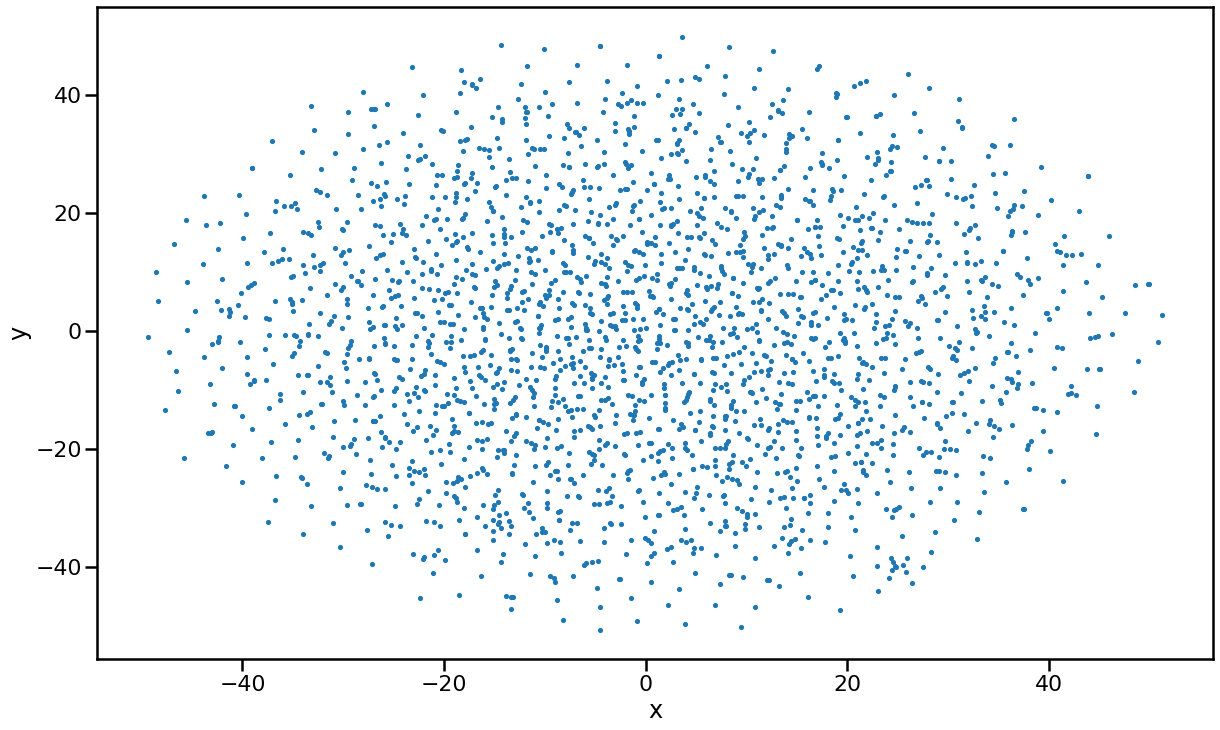

In [ ]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [ ]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(100, 80))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

2021-04-25 10:32:19,518 : INFO : NumExpr defaulting to 2 threads.


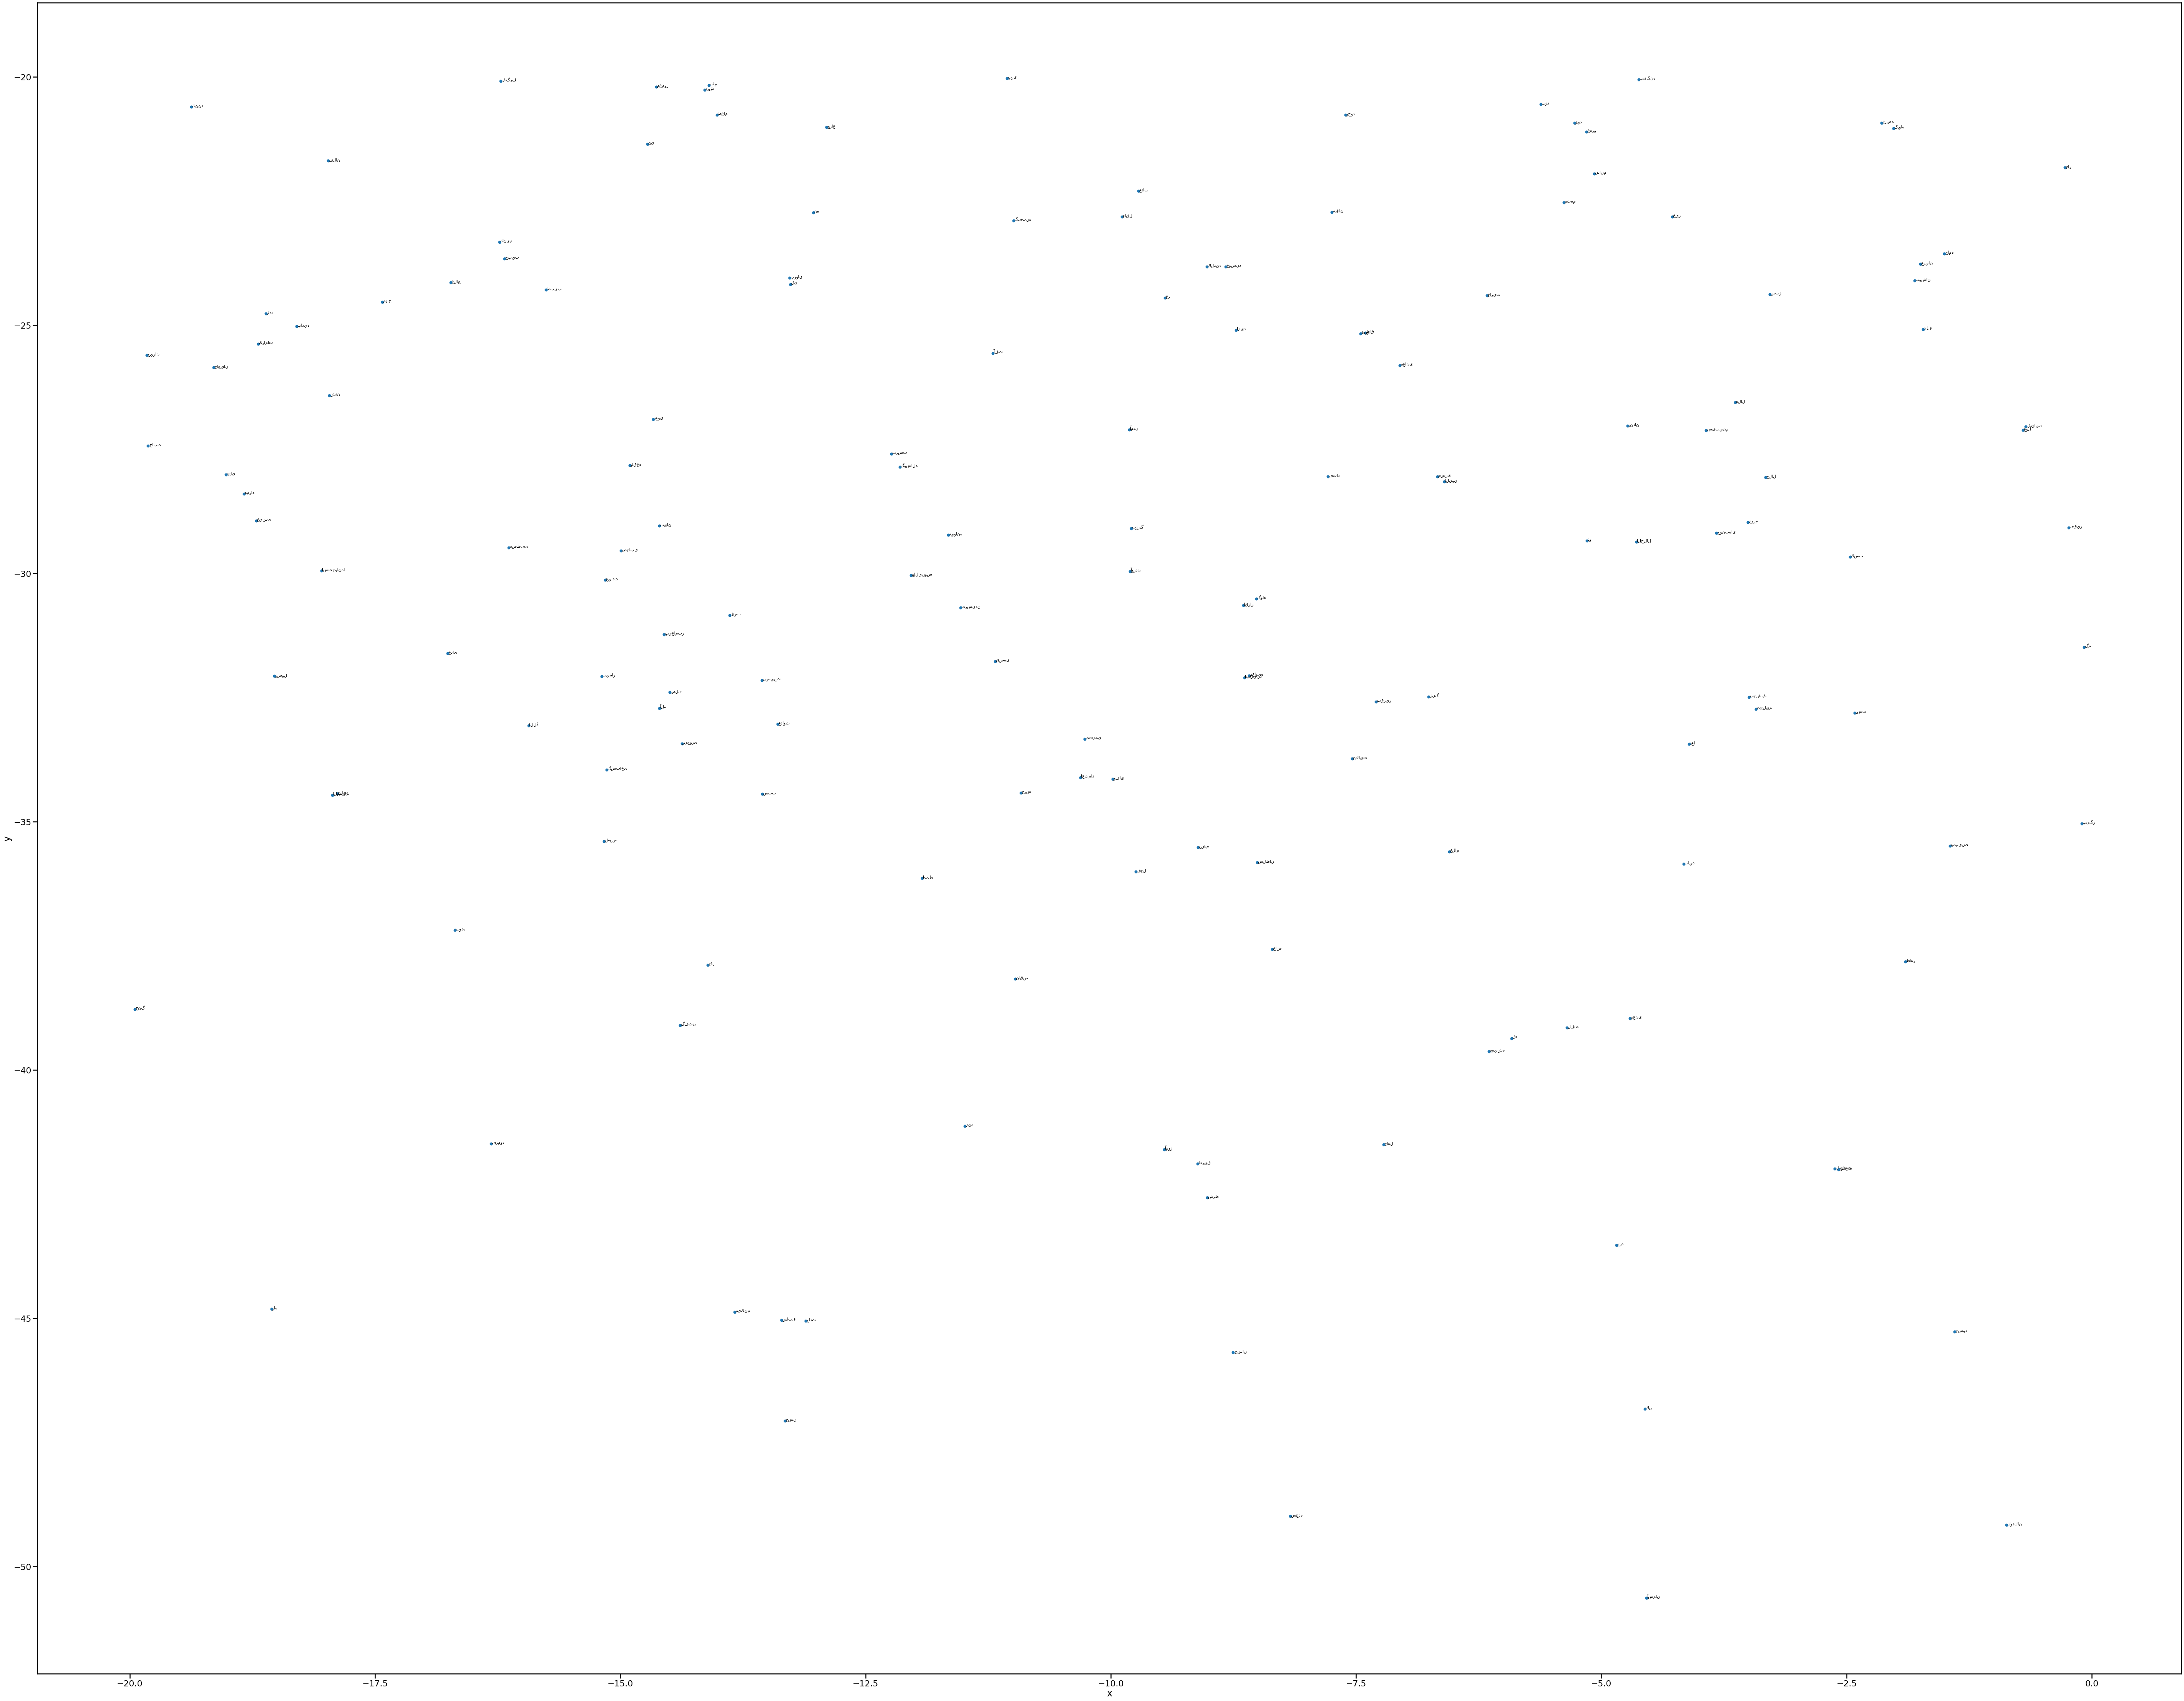

In [ ]:
plot_region(x_bounds=(-20, 0), y_bounds=(-60, -20))

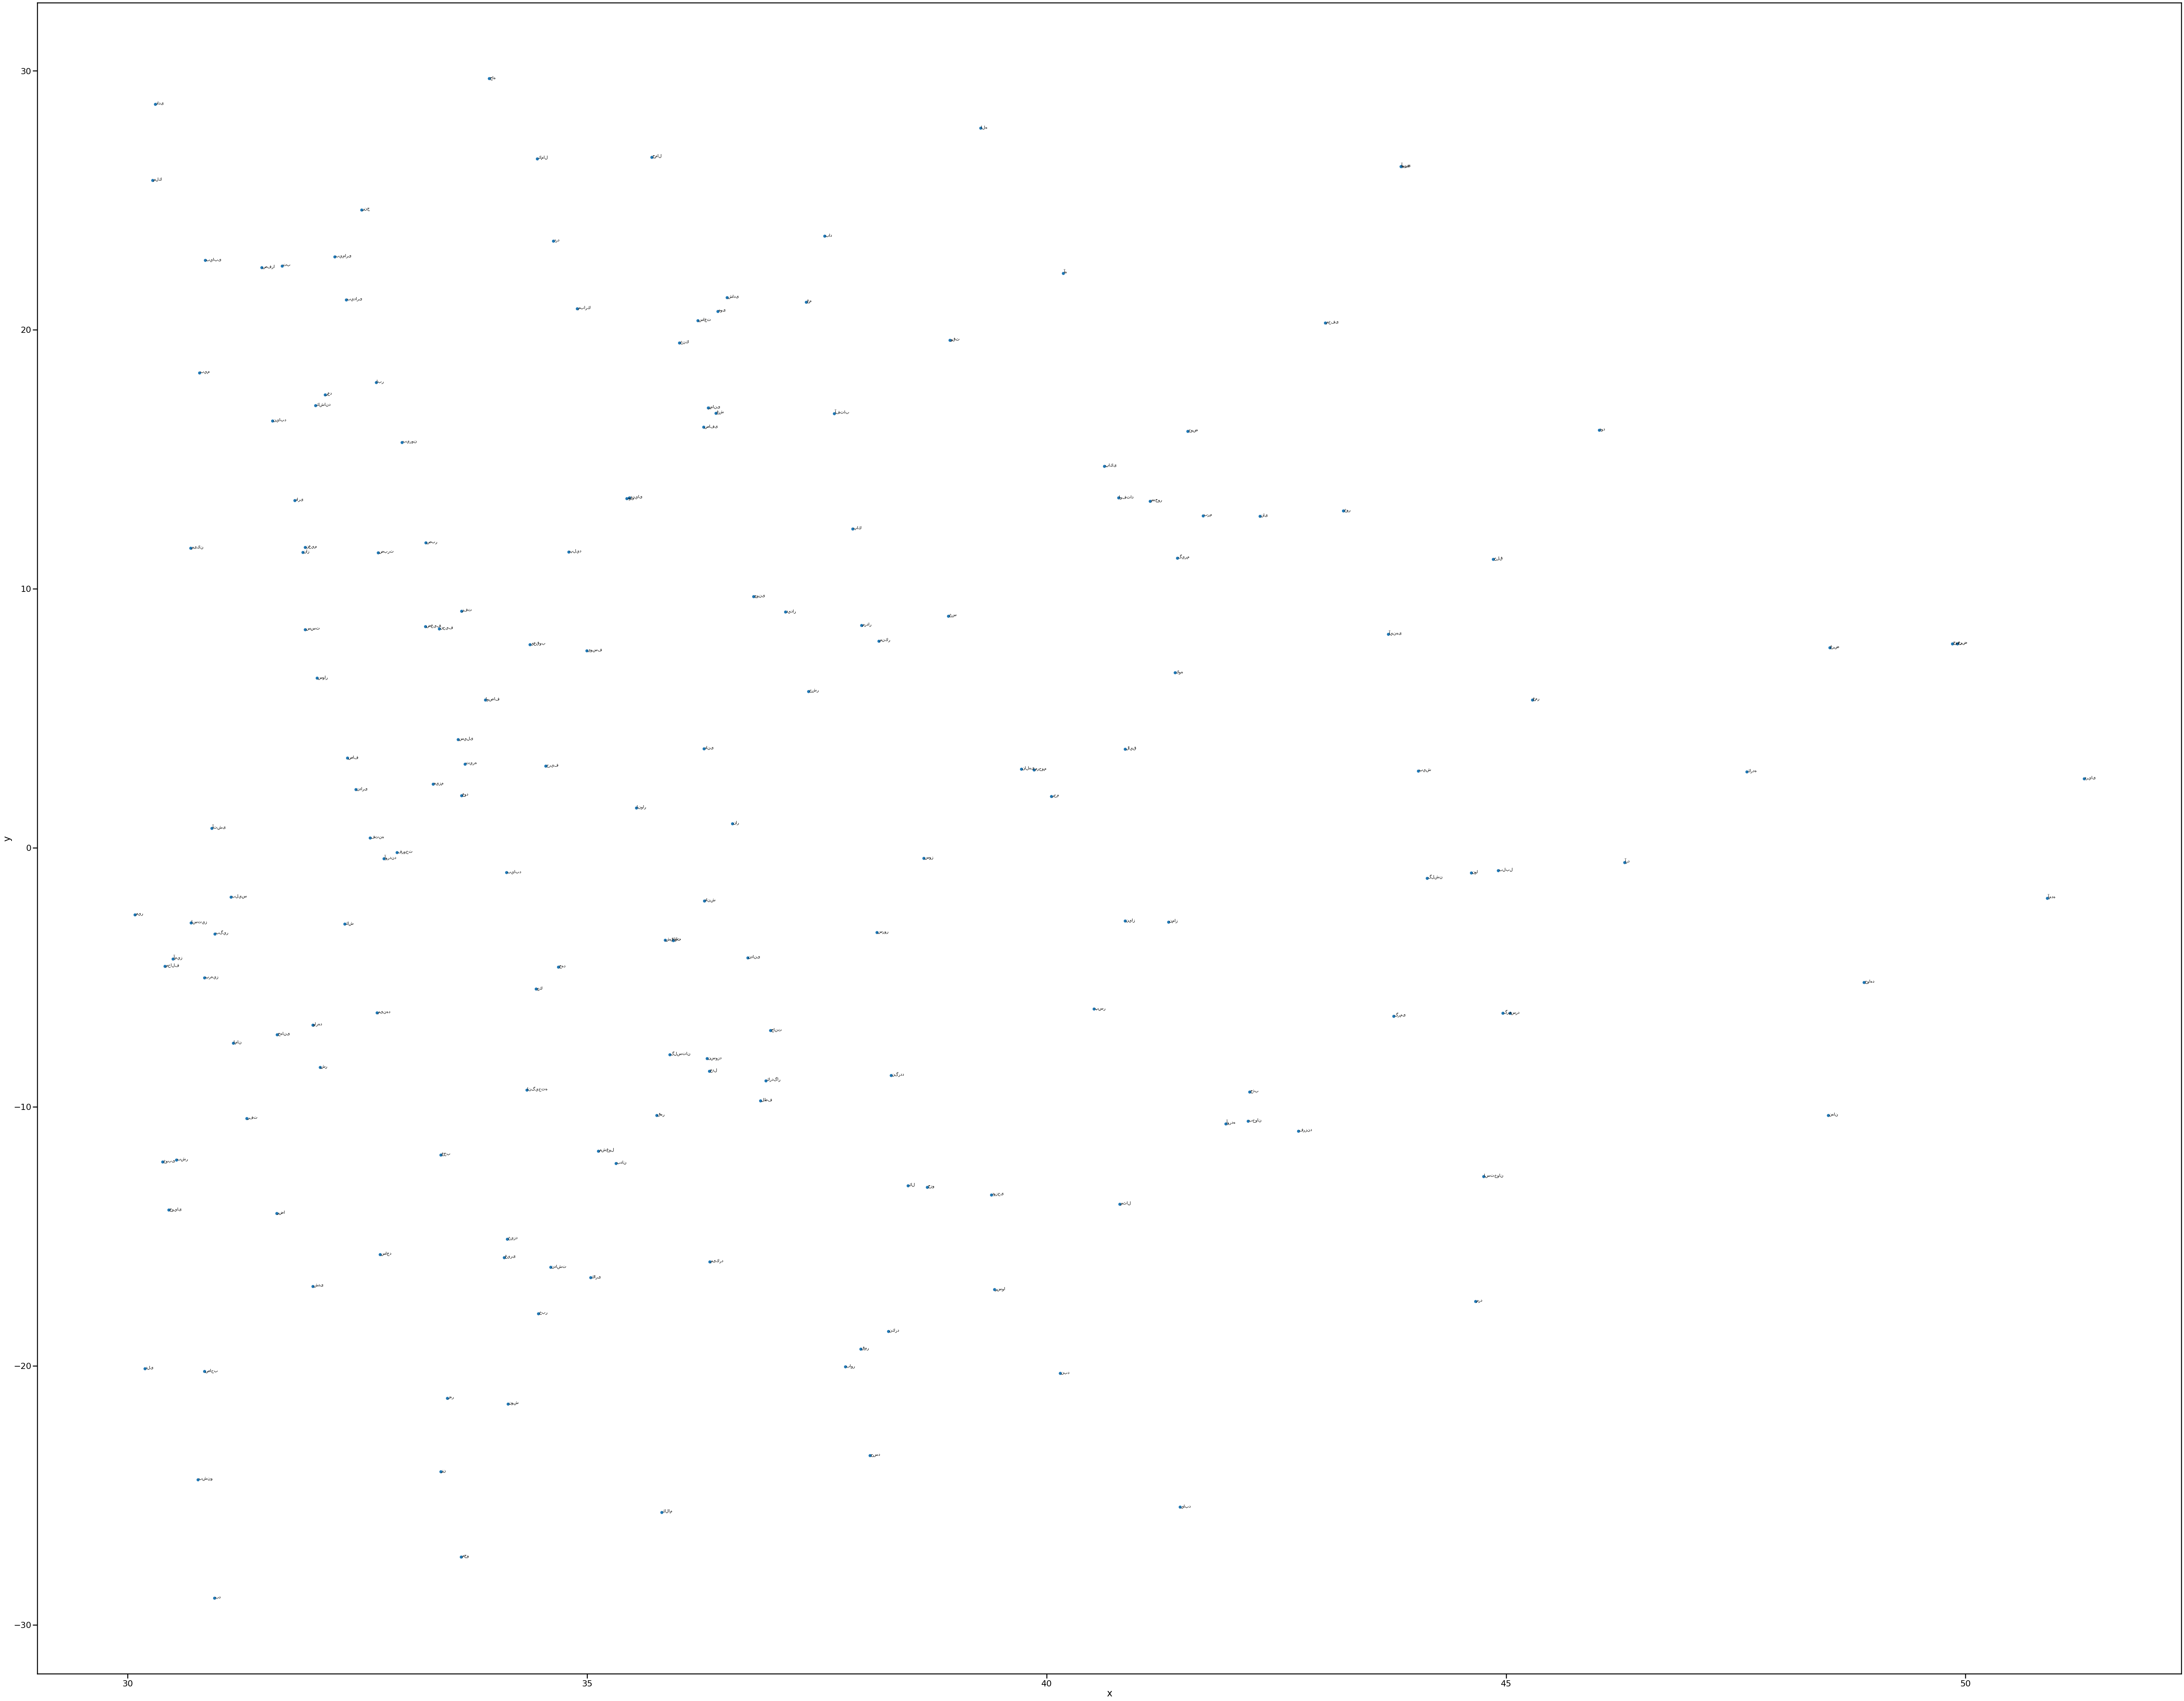

In [ ]:
plot_region(x_bounds=(30, 60), y_bounds=(-30, 30))

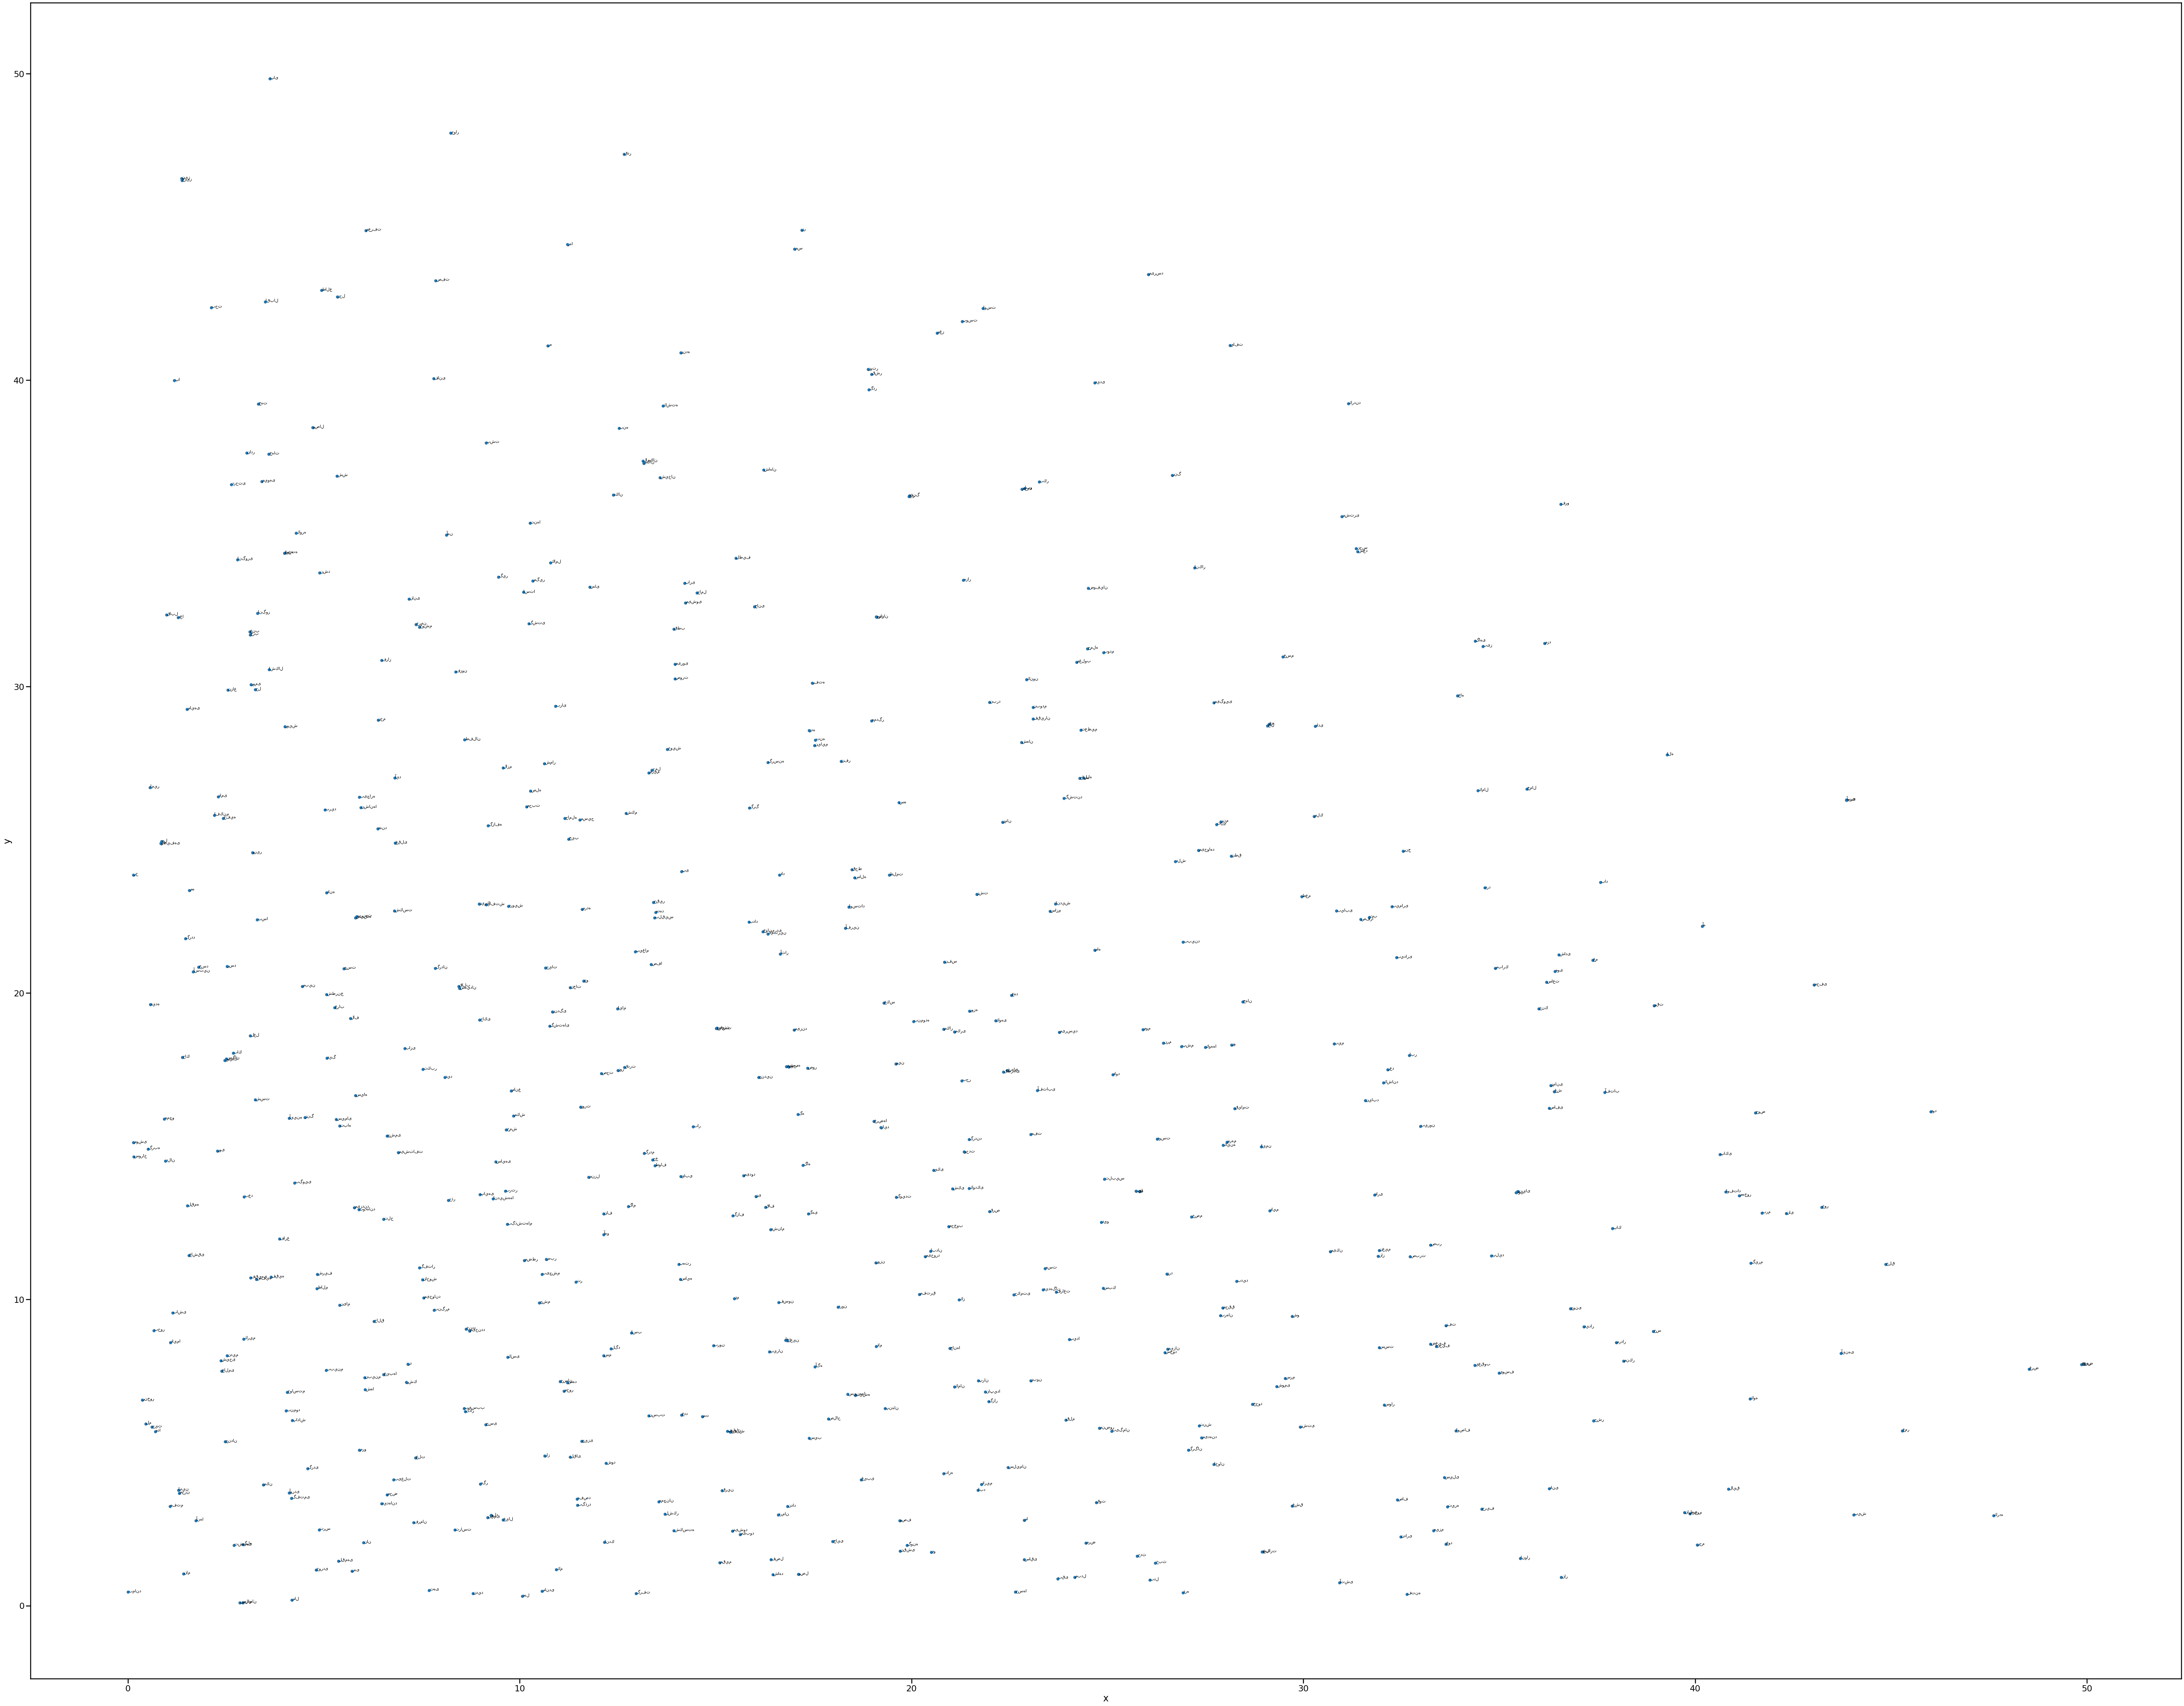

In [ ]:
plot_region(x_bounds=(0, 50), y_bounds=(0,50))

## **Explore semantic similarities between book characters**

**Words closest to the given word**

In [ ]:
model.most_similar("شمس")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2021-04-25 10:32:34,741 : INFO : precomputing L2-norms of word weight vectors


[('سببها', 0.5530619621276855),
 ('مطلع', 0.5404794216156006),
 ('فر', 0.5249759554862976),
 ('فى', 0.5050007104873657),
 ('دى', 0.46469545364379883),
 ('ناف', 0.43405675888061523),
 ('باور', 0.4336130619049072),
 ('مفتاح', 0.42773300409317017),
 ('سركه', 0.4247417151927948),
 ('شعاع', 0.4219633638858795)]

In [ ]:
model.most_similar("دوست")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('پوست', 0.5386593341827393),
 ('وحدت', 0.5162471532821655),
 ('مرهم', 0.5096783638000488),
 ('ريو', 0.48889344930648804),
 ('چشمت', 0.4706931412220001),
 ('خواست', 0.46316489577293396),
 ('عدو', 0.45088502764701843),
 ('مارى', 0.4370541274547577),
 ('دنيا', 0.4346889853477478),
 ('شكى', 0.4308663010597229)]

In [ ]:
model.most_similar("عشق")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('كوره', 0.4514436423778534),
 ('وفا', 0.4502394199371338),
 ('آفرين', 0.4205475449562073),
 ('باب', 0.4166167974472046),
 ('فزايد', 0.40945351123809814),
 ('دون', 0.4075055718421936),
 ('عبارت', 0.4055468440055847),
 ('اوستاد', 0.40436556935310364),
 ('اندرون', 0.40351220965385437),
 ('فتح', 0.3990574777126312)]

**Extract a word that doesnt match with**

In [ ]:
model.doesnt_match("نور باقى پهلوى دنياى دون شير صافى پهلوى جوهای خون".split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
2021-04-25 10:32:34,844 : WARNING : vectors for words {'جوهای'} are not present in the model, ignoring these words
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'نور'

**Linear relationships between word pairs**

In [ ]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = model.most_similar_cosmul( 
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [ ]:
nearest_similarity_cosmul("شمس", "قرآن", "علم")

شمس is related to قرآن, as تقليدى is related to علم


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'تقليدى'